# Narrative Text Generation (using RNN LSTM)

## Import dependencies

In [3]:
!pip install tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
!pip install tensorflow-addons
!pip install tensorflow-addons[keras]
import tensorflow_addons as tfa

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)


Defaulting to user installation because normal site-packages is not writeable


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 729.9/729.9 kB 2.1 MB/s eta 0:00:00


C:\Users\harin\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\harin\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file a

Defaulting to user installation because normal site-packages is not writeable
Python version: 3.9.13
Tensorflow version: 2.15.0


## Download the dataset

In [4]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

1115394/1115394 [==============================] - 0s 0us/step
/tmp\.keras\datasets\shakespeare.txt


## Analyze the dataset

In [5]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [6]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [7]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [8]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [9]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [10]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


## Create training sequences

In [11]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [12]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


In [13]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [15]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [16]:
dataset = sequences.map(split_input_target)

print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


In [17]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [19]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [20]:
# Batch size.
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int32, name=None), TensorSpec(shape=(64, 100), dtype=tf.int32, name=None))>

In [21]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


In [22]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 0  0 14 ... 43  1 42]
 [39 49 43 ...  1 58 56]
 [50 50  1 ... 40 43  1]
 ...
 [ 1 47 52 ... 57  1 45]
 [41 53 51 ... 43  1 51]
 [ 1 21  1 ... 61 47 42]], shape=(64, 100), dtype=int32)

1st batch: target_text: tf.Tensor(
[[ 0 14 30 ...  1 42 59]
 [49 43  1 ... 58 56 59]
 [50  1 46 ... 43  1 42]
 ...
 [47 52  1 ...  1 45 53]
 [53 51 54 ...  1 51 43]
 [21  1 44 ... 47 42 53]], shape=(64, 100), dtype=int32)


## Build the model



In [24]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)



1/1 [==============================] - 0s 108ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[7 8 2 2 3 4 3 0]
 [4 9 2 8 3 1 1 8]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.04194745 -0.02092146  0.04492955 -0.0317415  -0.0104738 ]
  [-0.03366889 -0.00224217 -0.0242735  -0.01285192  0.01265731]
  [-0.00538337  0.0167     -0.0111555   0.02911356 -0.04658346]
  [-0.00538337  0.0167     -0.0111555   0.02911356 -0.04658346]
  [ 0.03663247 -0.04585263  0.0366158  -0.01169821 -0.04041357]
  [ 0.00245354 -0.0076695  -0.00338166  0.00667476  0.01090804]
  [ 0.03663247 -0.04585263  0.0366158  -0.01169821 -0.04041357]
  [-0.01992288 -0.02995195  0.04312575 -0.04023232 -0.02352732]]

 [[ 0.00245354 -0.0076695  -0.00338166  0.00667476  0.01090804]
  [-0.04020399 -0.02239132 -0.02402937  0.04685834 -0.01930666]
  [-0.00538337  0.0167     -0.0111555   0.02911356 -0.04658346]
  [-0.03366889 -0.00224217 -0.0242735  -0.01285192  0.01265731]
  [ 0.03663247 -0.04585263  0.036615

In [25]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [26]:
def model_building(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

In [27]:
model = model_building(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           16640     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 65)            66625     
                                                                 
Total params: 5330241 (20.33 MB)
Trainable params: 5330241 (20.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Try the model

In [30]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [31]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-0.00295058  0.00037601 -0.00311453  0.00443059 -0.00629054  0.00354881
 -0.00249267  0.00171859 -0.00163355 -0.00183584  0.00079337  0.0028413
 -0.00295664 -0.00065028  0.00084772  0.00037077  0.00198076  0.00207451
  0.00233816  0.00111288 -0.00410818 -0.00400002 -0.00035115  0.00468105
  0.00820066  0.00098818 -0.00505097 -0.00191202 -0.00414158 -0.00211874
 -0.00458216  0.00478769 -0.00244158  0.00089159  0.00323366 -0.00253686
  0.00095674  0.00320679 -0.00177119  0.00012688 -0.00048592  0.00519498
 -0.0029637  -0.00308321  0.00053051  0.00315961  0.00449594  0.0053044
 -0.00586943 -0.00148945  0.00016275  0.00591684  0.00066272 -0.00028554
 -0.00548996 -0.00041482 -0.00020044  0.00219168  0.00383025 -0.00272997
 -0.00098081  0.00852826  0.00434048 -0.00421207  0.00461217], shape=(65,), dtype=float32)


In [32]:

tmp_logits = [
  [-0.95, 0, 0.95],
];

tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 1 1]], shape=(1, 5), dtype=int64)


In [33]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [34]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [35]:
sampled_indices

array([62,  1, 39, 42, 27, 39, 24, 22, 46, 24, 10, 63, 34, 51, 40, 43,  5,
       39, 18, 53, 32,  5, 26, 19, 12, 64,  4, 28, 25, 13, 29, 42, 50, 56,
       35, 24, 30, 48, 57, 63, 60, 33, 60,  4, 51, 24, 32, 30, 28, 58, 32,
       57, 28, 40, 53, 14, 55, 53, 52, 39, 43, 51,  8,  3, 20, 19, 58, 64,
        5, 44, 23, 31, 25,  2, 26, 51, 37, 25, 34, 26,  1, 43, 32, 39,  2,
       26, 53,  9, 44, 38, 41,  2,  3, 39, 64, 64,  8, 25, 39, 23],
      dtype=int64)

In [36]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 'tless is flight, they follow us with wings;\nAnd weak we are and cannot shun pursuit.\n\nRICHARD:\nAh, W'

Next char prediction:
 "x adOaLJhL:yVmbe'aFoT'NG?z&PMAQdlrWLRjsyvUv&mLTRPtTsPboBqonaem.$HGtz'fKSM!NmYMVN eTa!No3fZc!$azz.MaK"


In [37]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 58 ('t')
  next predicted: 1 ('x')
Prediction  1
  input: 50 ('l')
  next predicted: 1 (' ')
Prediction  2
  input: 43 ('e')
  next predicted: 1 ('a')
Prediction  3
  input: 57 ('s')
  next predicted: 1 ('d')
Prediction  4
  input: 57 ('s')
  next predicted: 1 ('O')


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [38]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.17475


In [39]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [40]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [42]:
EPOCHS=10

In [43]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/10

172/172 [==============================] - 571s 3s/step - loss: 2.5837
Epoch 2/10
172/172 [==============================] - 541s 3s/step - loss: 1.8741
Epoch 3/10
172/172 [==============================] - 547s 3s/step - loss: 1.6272
Epoch 4/10
172/172 [==============================] - 541s 3s/step - loss: 1.4959
Epoch 5/10
172/172 [==============================] - 558s 3s/step - loss: 1.4165
Epoch 6/10
172/172 [==============================] - 527s 3s/step - loss: 1.3614
Epoch 7/10
172/172 [==============================] - 463s 3s/step - loss: 1.3163
Epoch 8/10
172/172 [==============================] - 467s 3s/step - loss: 1.2764
Epoch 9/10
172/172 [==============================] - 459s 3s/step - loss: 1.2398
Epoch 10/10
172/172 [==============================] - 459s 3s/step - loss: 1.2051


In [44]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

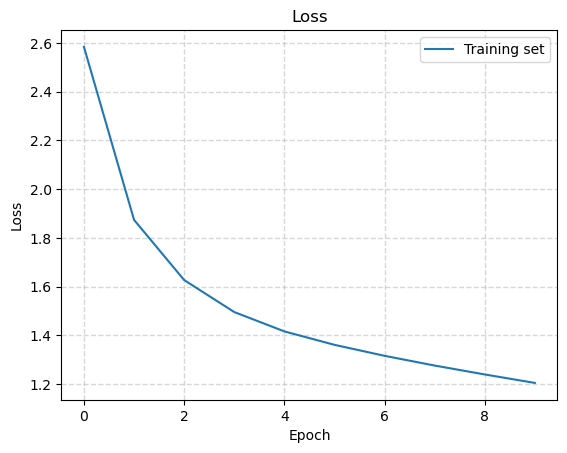

In [45]:
render_training_history(history)

## Generate text

In [46]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints\\ckpt_10'

In [48]:
simplified_batch_size = 1

model = model_building(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            16640     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 65)             66625     
                                                                 
Total params: 5330241 (20.33 MB)
Trainable params: 5330241 (20.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [51]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: gainted play, come not,
Stand and amogging to the secret, o'
For Rome, remains to she himself.
Obhy Plougina, what made they didder straight,
And called her to our promise and truth.

Masters:
Well, son Saint Bona, sit, madam: thou datest canst shang would have nothing
in a noble ender.

Nurshe Prince supposed and executed
As danger with against that true two ruel your rid be lough
ellow-det authors, upon appearers use
In this white letters.

CORIOLANUS:
Hear me, that Claudio.

PROSPERO:

CLARENCE:
To me, thou willd will it by so.
This deedy doth harm his evilence,
That though I teder lawing that this,
Some natural or woman! with my solemny
Will unflesh up to 'tch memory.

GREMIO:
What, ay for perchance, she came of you.

SICINIUS:
Nay, gentlemen, and you will pardon the ciult,
What think yoe, sir, thou trump't it discarding.

SAMPRON:
I have too set in pratenY For adlication!

All:
Consention, gentle siver.

HASTINGS:
I must be the nurse, though I thank y earth,
And yet put as 

In [52]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.5))

ROMEO: ECVINZZYHan worw,
And is' thus! O, Daze on, sou atan;
He'll be. Yet another wag to Rivers! Beserta:
Go, efped,
Neple noise, sit, llonme, thus hado
A plugs, proudempthy; Duke monrar's;
poislek him, planogs of her grossil, himself.

KING RICHARD XI:
The tigein Way
Prioug vicitumes, Ledio he join,
Impartly is report: fintil, nessew
smell'd: I must, thou muptturn, to make done sugh'd at death, e'er be obail? away?

LUCY apore
Frepporitrewook Rades: may I do,
Here comes thy poor brothero: dest Thy whom, by my shame
scafflects their heath:
Holdomio: what
saysoulthy,und IRe CAULINA:
If thou recumieding wan aboundmath'd: thou hast!
Taday love, let's har n their obmsire, high!
thine y?
Ish togls Cast ox I.
After,-awI'ld-ail the
UMEN:
Your winger-I a mocke it. Dearn coyt is this gue tom;
Clifford justion to What woe' by him:
Take up sumprigted,
How high I
Mirnowixt me from themzen's save--Frumion
He was witcen me: Mefenen'We accut witch,--a, gintwy, veinsford:
Drinnelve, gentlewell; and t